# Run OGGM with GCM data

In this example, we illustrate how to do a typical "projection run", i.e. using GCM data (here CMIP5). There are two important steps:
- simulate all glaciers from their inventory date up to a "present day" geometry (**New in version 1.4: this is already available in the pre-processed directories**)
- simulate their future evolution from the present day state

In [1]:
# Libs
import xarray as xr
import matplotlib.pyplot as plt

# Locals
import oggm.cfg as cfg
from oggm import utils, workflow, tasks
from oggm.core import gcm_climate

## Pre-processed directories

Let's do a run for two Himalayan glaciers: Ngojumba and Khumbu.

In [2]:
# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='WARNING')

# Here we override some of the default parameters
# How many grid points around the glacier?
# Make it large if you expect your glaciers to grow large:
# here, 40 is more than enough
cfg.PARAMS['border'] = 40

# Local working directory (where OGGM will write its output)
WORKING_DIR = utils.gettempdir('OGGM_gcm_run', reset=True)
utils.mkdir(WORKING_DIR, reset=True)
cfg.PATHS['working_dir'] = WORKING_DIR

# RGI glaciers: Ngojumba and Khumbu
rgi_ids = utils.get_rgi_glacier_entities(['RGI60-15.03473', 'RGI60-15.03733'])

# Go - get the pre-processed glacier directories
gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=5)

2021-02-03 10:04:01: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-02-03 10:04:01: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2021-02-03 10:04:01: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-02-03 10:04:01: oggm.cfg: PARAMS['border'] changed from `20` to `40`.
2021-02-03 10:04:03: oggm.workflow: init_glacier_directories from prepro level 5 on 2 glaciers.
2021-02-03 10:04:03: oggm.workflow: Execute entity task gdir_from_prepro on 2 glaciers


## New in version 1.4: the `_historical` runs

As of v1.4, the level 5 files now come with a pre-computed model run from the RGI outline date to the last possible date given by the historical climate data. These files are stored in the directory with a `_historical` suffix. Let's compile them for our two glaciers: 

2021-02-03 10:54:52: oggm.utils: Applying compile_run_output on 2 gdirs.


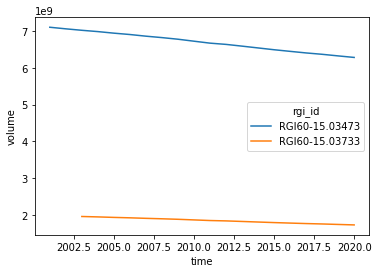

In [10]:
ds = utils.compile_run_output(gdirs, input_filesuffix='_historical')
ds.volume.plot(hue='rgi_id');

Each RGI glacier has an "inventory date", the time at which the ouline is valid. It can change between glaciers:

In [11]:
gdirs[0].rgi_date, gdirs[1].rgi_date

(2000, 2002)

In [12]:
ds.time[-1]

<xarray.DataArray 'time' ()>
array(2020.)
Coordinates:
    time            float64 2.02e+03
    hydro_year      int64 2020
    hydro_month     int64 1
    calendar_year   int64 2019
    calendar_month  int64 10
Attributes:
    description:  Floating hydrological year

The command that was run on preprocessing was the [run_from_climate_data](https://docs.oggm.org/en/latest/generated/oggm.tasks.run_from_climate_data.html#oggm.tasks.run_from_climate_data) task will run OGGM from this inventory date up to a desired date (here, the last year with valid historical climate data). So the data above is strictly equivalent to:

2021-02-03 10:54:57: oggm.workflow: Execute entity task run_from_climate_data on 2 glaciers
2021-02-03 10:54:58: oggm.utils: Applying compile_run_output on 2 gdirs.


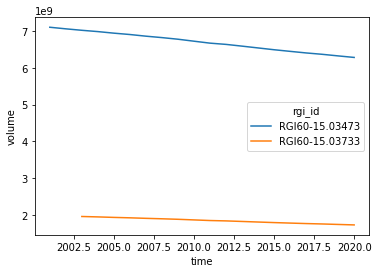

In [13]:
workflow.execute_entity_task(tasks.run_from_climate_data, gdirs, 
                             output_filesuffix='_my_spinup',  # to use the files as input later on
                            );
ds = utils.compile_run_output(gdirs, input_filesuffix='_my_spinup')
ds.volume.plot(hue='rgi_id');

One thing to remember here is that although we try hard to avoid spin-up issues, the glacier after the inversion is not in a perfect dynamical state. Some variable (in particular glacier length) might need some years to adjust:

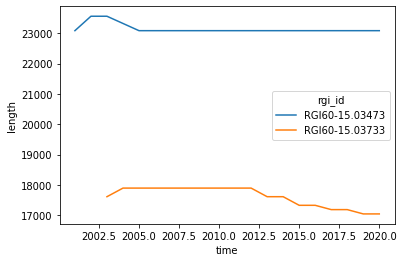

In [14]:
ds.length.plot(hue='rgi_id');

## Download and process GCM data 

A typical use case for OGGM will be to use climate model output (here CMIP5). We use some of the files [we store online](https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng) here, but you can use whichever you want. The above mentioned storage contains information about the data, [how to cite them](https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/ABOUT) and [tabular summaries](https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/gcm_table.html) of the available GCMs. 

We download the files and bias correct them to the calibration data (here: CRU). This step is very important, as the model is very sensitive to temperature variability.

In [15]:
bp = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/pr/pr_mon_CCSM4_{}_r1i1p1_g025.nc'
bt = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/tas/tas_mon_CCSM4_{}_r1i1p1_g025.nc'
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    # Download the files
    ft = utils.file_downloader(bt.format(rcp))
    fp = utils.file_downloader(bp.format(rcp))
    # bias correct them
    workflow.execute_entity_task(gcm_climate.process_cmip5_data, gdirs, 
                                 filesuffix='_CCSM4_{}'.format(rcp),  # recognize the climate file for later
                                 fpath_temp=ft,  # temperature projections
                                 fpath_precip=fp,  # precip projections
                                 );

2021-02-03 10:55:07: oggm.workflow: Execute entity task process_cmip5_data on 2 glaciers
2021-02-03 10:55:08: oggm.workflow: Execute entity task process_cmip5_data on 2 glaciers
2021-02-03 10:55:09: oggm.workflow: Execute entity task process_cmip5_data on 2 glaciers
2021-02-03 10:55:10: oggm.workflow: Execute entity task process_cmip5_data on 2 glaciers


## Projection runs 

We now run OGGM under various scenarios **and starting from the end year of the historical run**:

In [16]:
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    rid = '_CCSM4_{}'.format(rcp)
    workflow.execute_entity_task(tasks.run_from_climate_data, gdirs, ys=2020, 
                                 climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                 climate_input_filesuffix=rid,  # use the chosen scenario
                                 init_model_filesuffix='_historical',  # this is important! Start from 2020 glacier
                                 output_filesuffix=rid,  # recognize the run for later
                                );

2021-02-03 10:55:40: oggm.workflow: Execute entity task run_from_climate_data on 2 glaciers
2021-02-03 10:55:43: oggm.workflow: Execute entity task run_from_climate_data on 2 glaciers
2021-02-03 10:55:46: oggm.workflow: Execute entity task run_from_climate_data on 2 glaciers
2021-02-03 10:55:49: oggm.workflow: Execute entity task run_from_climate_data on 2 glaciers


## Plot model output 

2021-02-03 10:55:56: oggm.utils: Applying compile_run_output on 2 gdirs.
2021-02-03 10:55:56: oggm.utils: Applying compile_run_output on 2 gdirs.
2021-02-03 10:55:56: oggm.utils: Applying compile_run_output on 2 gdirs.
2021-02-03 10:55:56: oggm.utils: Applying compile_run_output on 2 gdirs.


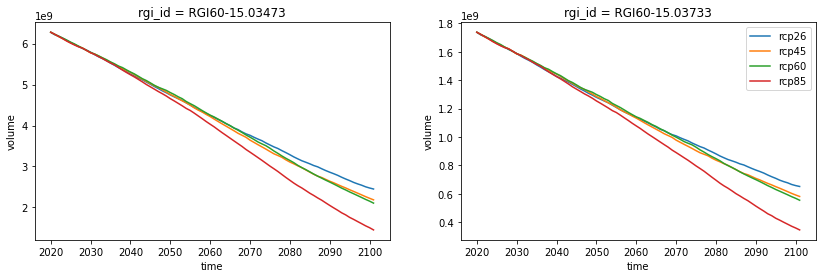

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    rid = '_CCSM4_{}'.format(rcp)
    ds = utils.compile_run_output(gdirs, input_filesuffix=rid)
    ds.isel(rgi_id=0).volume.plot(ax=ax1, label=rcp);
    ds.isel(rgi_id=1).volume.plot(ax=ax2, label=rcp);
plt.legend();

## What's next?

- return to the [OGGM documentation](https://docs.oggm.org)
- back to the [table of contents](welcome.ipynb)